In [0]:
%pip install featexp

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report
from pyspark.sql.functions import datediff, col
from pyspark.sql.functions import col, explode_outer, lpad, regexp_replace
from pyspark.sql import DataFrame, SparkSession
from pyspark.sql.functions import posexplode, concat, lit
import seaborn as sns


# Display all columns
pd.set_option('display.max_columns', None)

In [0]:
# read into a dataframe
# sql to join claims data with patient information and procedure data
raw=spark.sql(""" select diagnosis.claim_id,diagnosis.patient_id,diagnosis.date_service,diagnosis.date_service_end,diagnosis_code,enrollment.patient_gender,patient_year_of_birth,sum(procedure.line_charge) as paid_amt 
from healthverity_claims_sample_patient_dataset.hv_claims_sample.diagnosis 
inner join healthverity_claims_sample_patient_dataset.hv_claims_sample.enrollment on diagnosis.patient_id = enrollment.patient_id
inner join healthverity_claims_sample_patient_dataset.hv_claims_sample.procedure on diagnosis.patient_id = procedure.patient_id
where admit_diagnosis_ind='Y'
group by all""")
raw = raw.withColumnRenamed("date_service", "admission_dt").withColumnRenamed("date_service_end", "discharge_dt").withColumnRenamed("diagnosis_code","diag_cd")
print(raw.printSchema)
raw.show(2)

In [0]:
# convert to pandas
df = raw.toPandas()
df['admission_dt'] = pd.to_datetime(df['admission_dt'])
df['discharge_dt'] = pd.to_datetime(df['discharge_dt']) 

# Feature engineering: calculate length of stay
df['length_of_stay'] = (df['discharge_dt'] - df['admission_dt']).dt.days.astype('int') 
print("Number of null length_of_stay values:", df['length_of_stay'].isnull().sum())
# Calculate number of years of birth
df['patient_year_of_birth'] = df['patient_year_of_birth'].astype('int')
df['age'] = 2026 - df['patient_year_of_birth']
df['age_group'] = pd.cut(df['age'], bins=[0, 18, 35, 50, 65, 80, 100], labels=['0-18', '19-35', '36-50', '51-65', '66-80', '81-100'])

df.head(2)

Number of null length_of_stay values: 0


,claim_id,patient_id,admission_dt,discharge_dt,diag_cd,patient_gender,patient_year_of_birth,paid_amt,length_of_stay,age,age_group
0,fad89d0b186063f393bb82e8cc50c1fb,46efcda6fafac85bfc9735969d26afc8,2019-07-11,2019-07-14,R531,M,1944,141109.661281,3,82,81-100
1,f73e9acb6759baf704968975b9e92c64,0a3e83e5fc70ce368803d9f3c16a42ce,2023-09-03,2023-09-09,F1120,M,1986,876162.433148,6,40,36-50


---------------------------------------------------------------------------
AttributeError                            Traceback (most recent call last)
~/.ipykernel/2585/command-8703513654170469-1883384940 in ?()
      9 # Calculate number of years of birth
     10 df['patient_year_of_birth'] = df['patient_year_of_birth'].astype('int')
     11 df['age'] = 2026 - df['patient_year_of_birth']
     12 df['age_group'] = pd.cut(df['age'], bins=[0, 18, 35, 50, 65, 80, 100], labels=['0-18', '19-35', '36-50', '51-65', '66-80', '81-100'])
---> 13 df.show(2)

/databricks/python/lib/python3.12/site-packages/pandas/core/generic.py in ?(self, name)
   6295             and name not in self._accessors
   6296             and self._info_axis._can_hold_identifiers_and_holds_name(name)
   6297         ):
   6298             return self[name]
-> 6299         return object.__getattribute__(self, name)

AttributeError: 'DataFrame' object has no attribute 'show'

                                       Plots for length_of_stay                                       


/local_disk0/.ephemeral_nfs/envs/pythonEnv-07f84cf0-0fbc-4934-9f72-cff33a3f6bbd/lib/python3.12/site-packages/featexp/base.py:55: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = input_data.groupby([cut_series], as_index=True).agg(
/local_disk0/.ephemeral_nfs/envs/pythonEnv-07f84cf0-0fbc-4934-9f72-cff33a3f6bbd/lib/python3.12/site-packages/featexp/base.py:55: FutureWarning: The provided callable <function mean at 0xff81f410cfe0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  grouped = input_data.groupby([cut_series], as_index=True).agg(


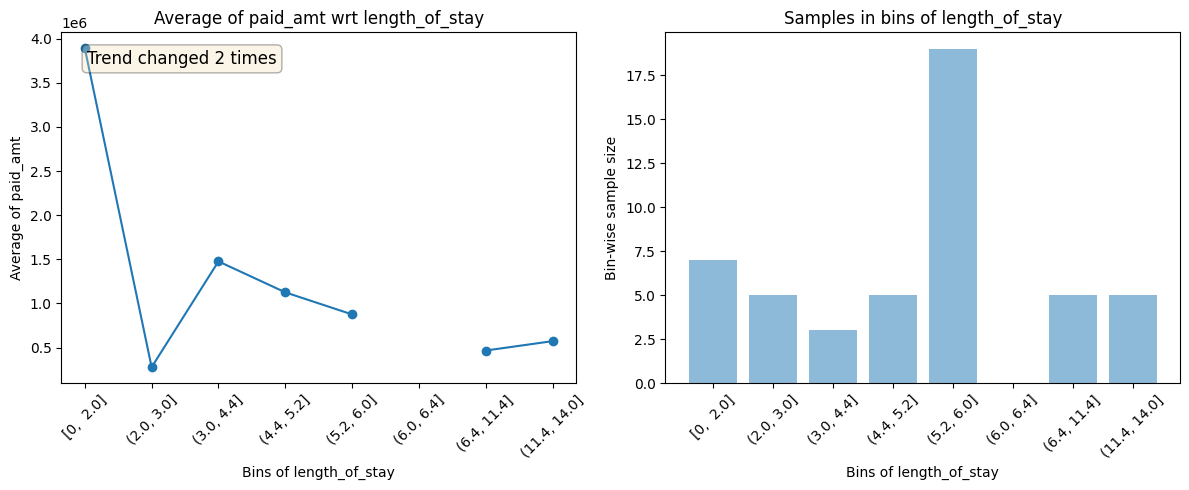

--------------------------------------------------------------------------------------------------------------




In [0]:
from featexp import get_univariate_plots

df_train = df
# Call the function to generate univariate plots
get_univariate_plots(df, 
                     'paid_amt', 
                     ['length_of_stay'])
# below graph shows no strong correlation between paid_amt and length_of_stay

                                            Plots for age                                             


/local_disk0/.ephemeral_nfs/envs/pythonEnv-07f84cf0-0fbc-4934-9f72-cff33a3f6bbd/lib/python3.12/site-packages/featexp/base.py:55: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = input_data.groupby([cut_series], as_index=True).agg(
/local_disk0/.ephemeral_nfs/envs/pythonEnv-07f84cf0-0fbc-4934-9f72-cff33a3f6bbd/lib/python3.12/site-packages/featexp/base.py:55: FutureWarning: The provided callable <function mean at 0xff81f410cfe0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  grouped = input_data.groupby([cut_series], as_index=True).agg(


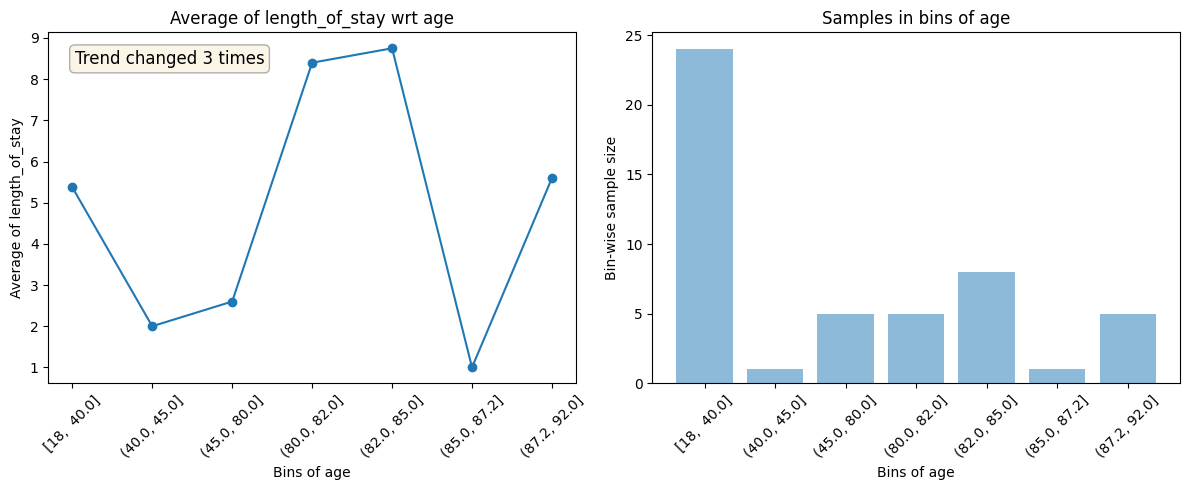

--------------------------------------------------------------------------------------------------------------




---------------------------------------------------------------------------
TypeError                                 Traceback (most recent call last)
File <command-4844301513464024>, line 1
----> 1 get_univariate_plots(df, 
      2                      'age_group', 
      3                      ['length_of_stay'])

File /local_disk0/.ephemeral_nfs/envs/pythonEnv-07f84cf0-0fbc-4934-9f72-cff33a3f6bbd/lib/python3.12/site-packages/featexp/base.py:330, in get_univariate_plots(data, target_col, features_list, bins, data_test)
    325     print(
    326         cols
    327         + " is categorical. Categorical features not supported yet."
    328     )
    329 elif cols != target_col and data[cols].dtype != "O":
--> 330     univariate_plotter(
    331         feature=cols,
    332         data=data,
    333         target_col=target_col,
    334         bins=bins,
    335         data_test=data_test,
    336     )

File /local_disk0/.ephemeral_nfs/envs/pythonEnv-07f84cf0-0fbc-4934-9f72-c

In [0]:
get_univariate_plots(df, 
                     'length_of_stay', 
                     ['age'])

# As seen below, between age 40 and 82, as the age increases so does the length of stay. 